# Lab 2: Homography estimation and applications

In this lab you will learn how to estimate a homography relating two images given a set of correspondences between them. Then, you will work with different computer vision applications of the homography.

More precisely, the goals are:

1) Homography estimation with the DLT algorithm. <br>

2) Application: Image mosaics. <br>

3) Refinement of the estimated homography with the Gold Standard algorithm. <br>

4) Application: Camera calibration with a planar pattern and augmented reality. <br>

5) Application: Logo detection. <br>

6) Application: Logo replacement.

The following file combines some text cells (Markdown cells) and code cells. Some parts of the code need to be completed. All tasks you need to complete are marked in <span style='color:Green'> green.  </span>

In [1]:
!pip install opencv-contrib-python

In [1]:
import numpy as np
import cv2
import math
import sys
import matplotlib
from matplotlib import  pyplot as plt
from operator import itemgetter
from utils import apply_H_fixed_image_size, plot_img, Ransac_DLT_homography
import os
from scipy.linalg import cholesky
import random
from scipy.optimize import least_squares

In [2]:
DATA_PATH="../../Data_Lab2/"

## **1. Homography estimation with the DLT algorithm**

### **1.1 Compute image correspondences**
Execute the following code to find image correspondences using ORB [1] (you may also use SIFT, SURF, etc)

[1] Ethan Rublee, Vincent Rabaud, Kurt Konolige, Gary R. Bradski: ORB: An efficient alternative to SIFT or SURF. ICCV 2011: 2564-2571.

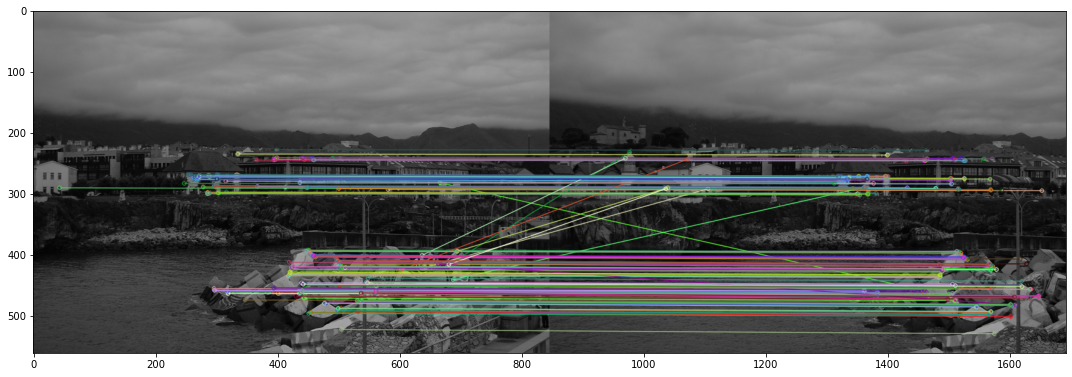

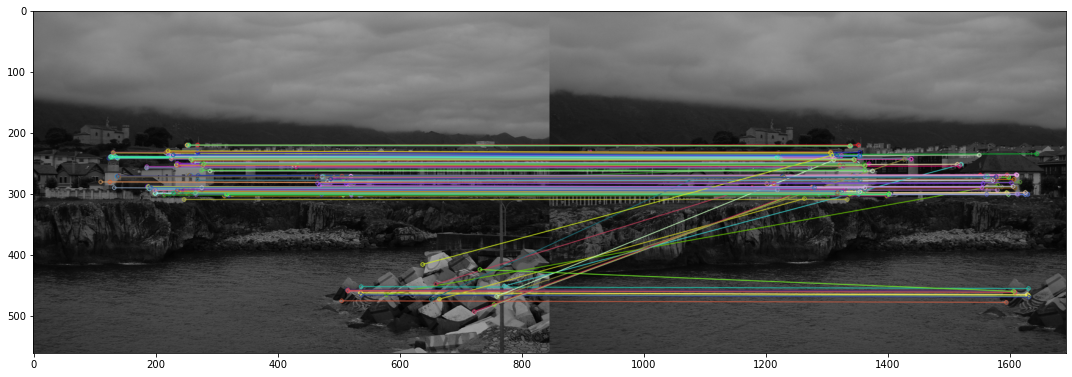

In [168]:
# Read images
img1 = cv2.imread(os.path.join(DATA_PATH, 'llanes/llanes_a.jpg'),cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(DATA_PATH, 'llanes/llanes_b.jpg'),cv2.IMREAD_GRAYSCALE)
img3 = cv2.imread(os.path.join(DATA_PATH, 'llanes/llanes_c.jpg'),cv2.IMREAD_GRAYSCALE)

# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)
kp3, des3 = orb.detectAndCompute(img3,None)

# Keypoint matching
# Keypoint matching 

#Note for Discussion
## (Use Hamming distance isntead for ORB descriptors)
#Increases number of good matches from (151 and 176) to (182 and 243)

#bf = cv2.BFMatcher()
bf = cv2.BFMatcher(normType=cv2.NORM_HAMMING)
matches_12 = bf.knnMatch(des1,des2,k=2)
# Apply ratio test
good_matches_12 = []
for m,n in matches_12:
    if m.distance < 0.85*n.distance:
        good_matches_12.append([m])

matches_23 = bf.knnMatch(des2,des3,k=2)
# Apply ratio test
good_matches_23 = []
for m,n in matches_23:
    if m.distance < 0.85*n.distance:
        good_matches_23.append([m])


# Show "good" matches 
img_12 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches_12,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_12)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

img_23 = cv2.drawMatchesKnn(img2,kp2,img3,kp3,good_matches_23,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_23)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

### **1.2 Compute the homography (DLT algorithm) between image pairs**

The following cell of code calls the 'Ransac_DLT_homography' function from utils.py
Before running the code of the cell you first need to complete some functions in utils.py that are called from 'Ransac_DLT_homography' function:

<span style='color:Green'> - Complete the 'DLT_homography' function that computes a homography from a set of point correspondences with the DLT algorithm.  </span>

<span style='color:Green'> - Complete the 'Inliers' function that, given a homography, a set of point correspondences and a certain threshold  returns the indices of the correspondences that are inliers.  </span>


In [169]:
# Homography between images 1 and 2
points1 = []
points2 = []
for m in good_matches_12:
    points1.append([kp1[m[0].queryIdx].pt[0], kp1[m[0].queryIdx].pt[1], 1])
    points2.append([kp2[m[0].trainIdx].pt[0], kp2[m[0].trainIdx].pt[1], 1])    

points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

In [170]:
def normalize_points(points):
    means = np.mean(points, axis=1)
    mean_x = means[0]
    mean_y = means[1]
    
    dist = np.sqrt((np.square(points[0] - mean_x)) + np.square(points[1] - mean_y))
    mean_dist = np.mean(dist)
    
    s = np.sqrt(2)/mean_dist
    tx = -s*mean_x
    ty = -s*mean_y
    
    T = np.array([[s,0, tx],
                 [0, s, ty],
                 [0,0,1]])
    
    norm_points = T@points
    return norm_points, T

In [171]:
def get_equations_from_points(p1, p2):
    x,y,w = p1;x = x/w;y= y/w
    
    x_p,y_p,w_p = p2;x_p = x_p/w_p;y_p = y_p/w_p
    
    eq1 = np.array([-x, -y, -1, 0, 0, 0, x*x_p, y*x_p, x_p])
    eq2 = np.array([0, 0, 0, -x, -y, -1, x*y_p, y*y_p, y_p])
    return eq1,eq2

In [172]:
def DLT_homography(points1, points2):
    """
    points are assumed to be in (3,num_points) format
    """
    #normalize the points
    points1, T1 = normalize_points(points1)
    points2, T2 = normalize_points(points2)
    
    num_points = points1.shape[1]
    Eq_list = []
    for point1, point2 in zip(points1.T,points2.T):
        eq1,eq2 = get_equations_from_points(point1,point2)
        Eq_list.append(eq1)
        Eq_list.append(eq2)
        
    Eq = np.array(Eq_list)
    
    U,D,Vt = np.linalg.svd(Eq)
    
    # take the last row of V_transpose
    # this is equivalent to taking the last column of V
    H_tilde = np.reshape(Vt[-1],(3,3))
    
    T2_inv = np.linalg.inv(T2)
    
    H = T2_inv@H_tilde@T1
    # ToDo: complete this code .......
    
    #normalize
    H = H/H[-1,-1]
    
    return H

In [173]:
H, _ = Ransac_DLT_homography(points1,points2, 3, 1000);H

array([[ 9.82026009e-01,  4.42675932e-03,  2.17650079e+02],
       [ 3.84699133e-03,  9.98097657e-01, -2.53555679e+00],
       [-3.12516029e-05,  2.40920423e-06,  1.00000000e+00]])

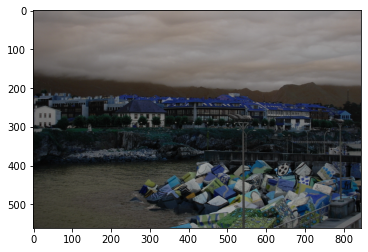

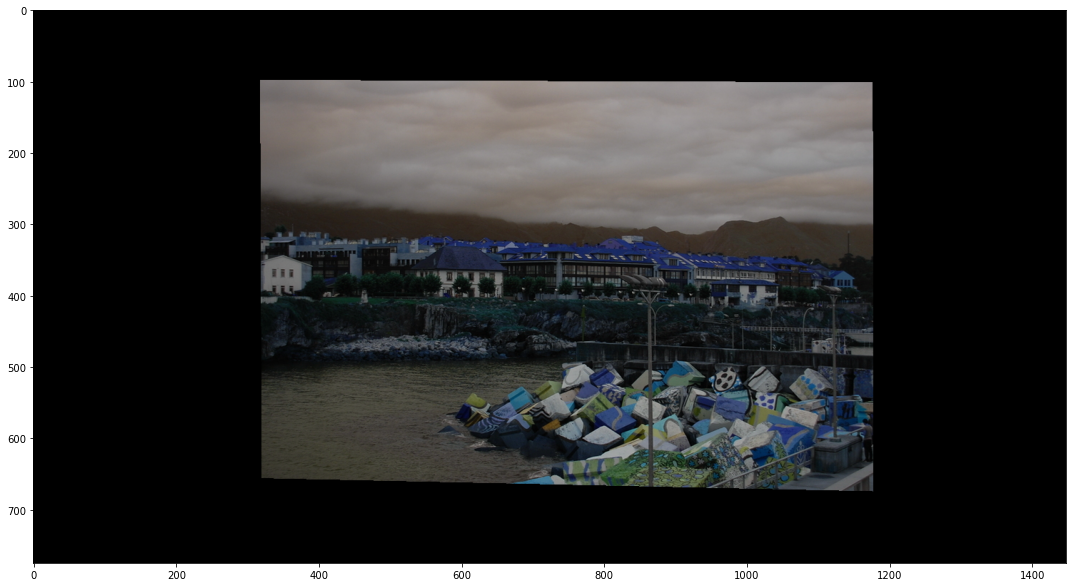

In [174]:
img1 = cv2.imread(os.path.join(DATA_PATH, 'llanes/llanes_a.jpg'))#,cv2.IMREAD_GRAYSCALE)
im = apply_H_fixed_image_size(img1, H, (-100, img1.shape[1] + 500, -100, img1.shape[0]*1.2))

plt.imshow(img1)
plt.show()
plt.imshow(im)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## **2. Application: Image mosaics**

Now that the homographies relating the images have been estimated we can create a mosaic by properly transforming and fusing the different image contents.
For that we create a big enough canvas where the mosaic will be created. The function 'apply_H_fixed_image_size' is provided in utils.py, it is a variant of the 'apply_H' function from lab 1 where this time the size of the transformed is fixed and given as an extra input.

<span style='color:Green'> - Complete the 2nd input argument to the 'apply_H_fixed_image_size' function in order to get the image mosaic. </span>


<span style='color:Green'> - Compute the mosaic with castle_int images. </span>

<span style='color:Green'> - Compute the mosaic with aerial images set 13 </span>

<span style='color:Green'> - Compute the mosaic with aerial images set 22 </span>

<span style='color:Green'> - In the report, comment the results in every of the four cases: hypothetise why it works or does not work </span>

## **3. Refinement of the estimated homography with the Gold Standard algorithm**

In order to refine the previous estimated homography we can minimize the geometric error with the Levenberg-Marquardt algorithm. For that we will call the function 'least_squares' with the proper input arguments that you have to complete. First, it is recommended to read the documentation of that function:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html

Notice that the first input is a function that only provides the vector of the residuals. The algorithm constructs the cost function as a sum of squares of the residuals. In our case the function is called 'geometric_error_terms' and you need to complete it.

More precisely, the tasks to perform are:

<span style='color:Green'> - Complete the function 'geometric_error_terms'. </span>

<span style='color:Green'> - Complete the code before calling function 'geometric_error_terms' in order to create the proper input of variables, 'variables0', to pass to the function. </span>

<span style='color:Green'> - Extract the refined homogaphy and the refined keypoint locations from the output, 'result', of function 'geometric_error_terms'.  </span>

<span style='color:Green'> - To better compare the two homographies (refined and non refined) compute and print the geometric error before and after the refinement. </span>

<span style='color:Green'> - Refine the homography 23 with the Gold Standard algorithm and visualize the differences in the keypoint locations. </span>

<span style='color:Green'> - Build mosaic with the refined homographies. </span>

True

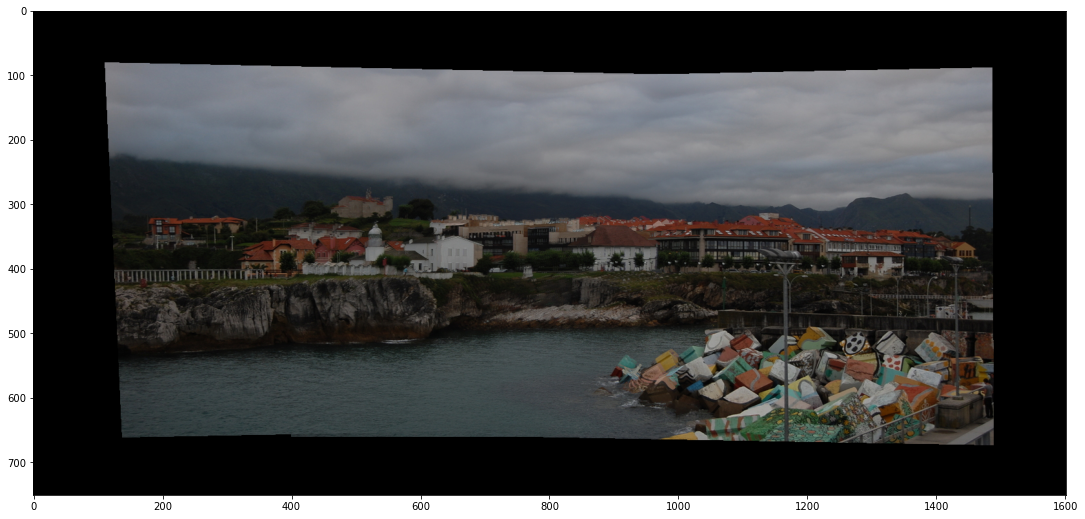

In [179]:
corners = [-400, 1200, -100, 650] # corners of the canvas where the mosaic will be created

#print(img1.shape)
img1c = cv2.imread(os.path.join(DATA_PATH, "llanes/llanes_a.jpg"),cv2.IMREAD_COLOR)
img2c = cv2.imread(os.path.join(DATA_PATH, "llanes/llanes_b.jpg"),cv2.IMREAD_COLOR)
img3c = cv2.imread(os.path.join(DATA_PATH, "llanes/llanes_c.jpg"),cv2.IMREAD_COLOR)
img1c = cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB)
img2c = cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB)
img3c = cv2.cvtColor(img3c, cv2.COLOR_BGR2RGB)

img1c_w = apply_H_fixed_image_size(img1c, H_12, corners) # complete the call to the function
img2c_w = apply_H_fixed_image_size(img2c, np.eye(3), corners) # complete the call to the function
img3c_w = apply_H_fixed_image_size(img3c, np.linalg.inv(H_23), corners) # complete the call to the function

img_mosaic = np.maximum(img3c_w,np.maximum(img1c_w,img2c_w))
plot_img(img_mosaic)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
img_mosaic = cv2.cvtColor(img_mosaic, cv2.COLOR_RGB2BGR)
cv2.imwrite('mosaic_llanes.png', img_mosaic) 

In [180]:
def add_ones_dim(x):
    return np.array([x[0],x[1],np.ones_like(x[1])])

def remove_ones_dim(x):
    x = x/x[2]
    return np.array([x[0],x[1]])

def geometric_error_terms(P0, Xobs):
    H = np.reshape(P0[0:9],(3,3))
    npoints = int(len(Xobs)/2)
    x = Xobs[:npoints]
    xp = Xobs[npoints:]
    
    #reshape back to original sizes
    x = np.reshape(x,(2,-1))
    xp = np.reshape(xp,(2,-1))
    
    # get optimal x_hat andx_hatp
    xhat = P0[9:]
    xhat = np.reshape(xhat,(2,-1))
    xhatp = remove_ones_dim(H@add_ones_dim(xhat))
    
    def get_l2_dist(a,b):
        return np.sum(np.square(a - b), axis=0)
    
    e1 = get_l2_dist(x,xhat)
    e2 = get_l2_dist(xp, xhatp)
    
    E = np.sqrt(e1+e2)
    return E




Old error is 0.6322305080202137
New Error is 0.0


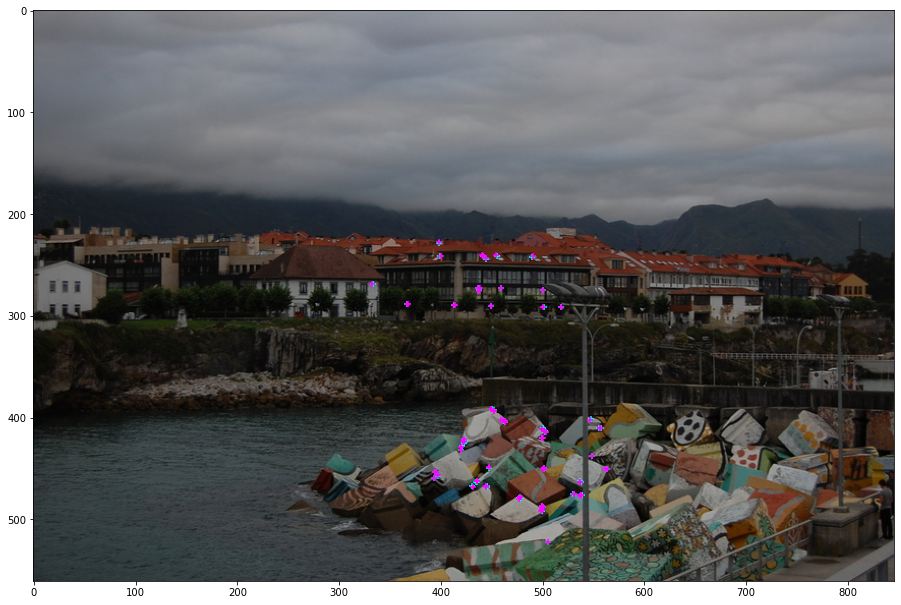

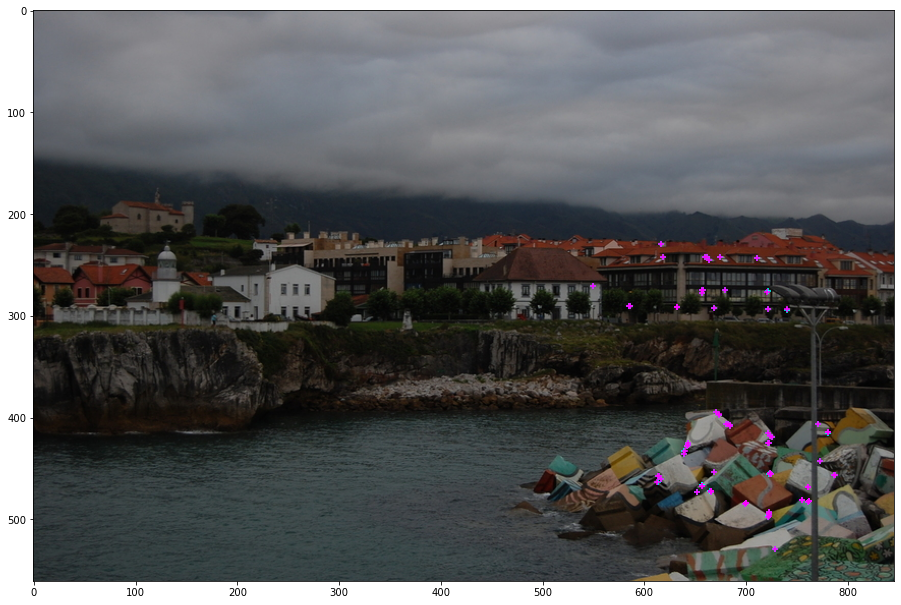

In [185]:
points1 = []
points2 = []

for m in inlier_matches_12:
    points1.append([kp1[m[0].queryIdx].pt[0], kp1[m[0].queryIdx].pt[1]])
    points2.append([kp2[m[0].trainIdx].pt[0], kp2[m[0].trainIdx].pt[1]])

points1 = np.asarray(points1)
points1 = points1.T
points2 = np.asarray(points2)
points2 = points2.T

Xobs = np.concatenate([points1.flatten(),points2.flatten()])
P0 = np.concatenate([H_12.flatten(),points1.flatten()])

result = least_squares(geometric_error_terms, P0, method='trf', args=([Xobs]))

Pr = result.x
H_12r = np.reshape(Pr[:9],(3,3))

xhat = Pr[9:]
xhat = np.reshape(xhat,(2,-1))
xhatp = remove_ones_dim(H_12r@add_ones_dim(xhat))

Xobsr = np.concatenate([xhat.flatten(),xhatp.flatten()])
P0r = np.concatenate([H_12r.flatten(), xhat.flatten()])

old_error = np.mean(geometric_error_terms(P0, Xobs))
print(f'Old error is {old_error}')

new_error = np.mean(geometric_error_terms(P0r, Xobsr))
print(f'New Error is {new_error}')

points1r = xhat
points2r = xhatp

# display points and refined points
fig, ax = plt.subplots() # image 1
ax.imshow(img1c)
ax.scatter(points1[0,:],points1[1,:], c='cyan', marker='+')
ax.scatter(points1r[0,:],points1r[1,:], c='fuchsia', marker='+')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

fig, ax = plt.subplots() # image 2
ax.imshow(img2c)
ax.scatter(points2[0,:],points2[1,:], c='cyan', marker='+')
ax.scatter(points2r[0,:],points2r[1,:], c='fuchsia', marker='+')
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

## **4. OPTIONAL. Application: Calibration with a planar pattern and augmented reality**

As we have seen in class, we can calibrate a camera with a planar pattern with Zhang's algorithm. A key aspect of this algorithm is the estimation of a homography that relates a pair of images, in particular, the template image and an image of it taken with the camera we want to calibrate. Once the camera is calibrated and we have recovered the relative pose between the camera and the planar pattern we can properly insert a virtual object on top of the flat pattern in a way that it is consistent, in a perspective sense, with rest of the scene.

### **4.1 Camera calibration**

The following code calibrates a camera using N (where N greater or equal than three) views of the planar pattern. Most of the code is provided but there are parts you need to complete. These parts are indicated in green before the corresponding cell code.


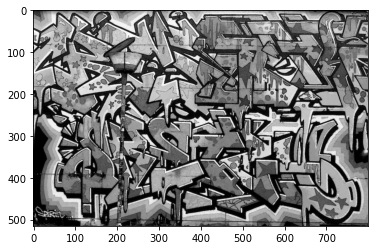

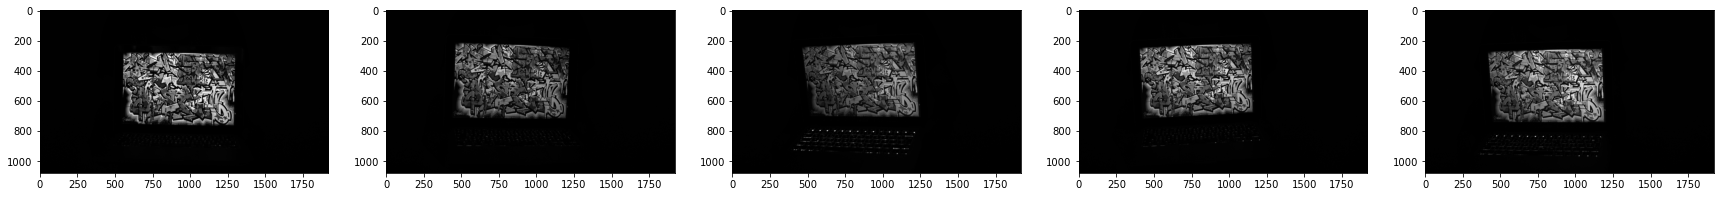

In [69]:

# Read template image and calibration images
template = cv2.imread(os.path.join(DATA_PATH, 'calib/template.jpg'),cv2.IMREAD_GRAYSCALE)

plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
plt.show()

images = []
N = 5 # 3, 4, or 5
fig, ax = plt.subplots(1,N, figsize=(30,15))
for i in range(1,N+1):
    m = cv2.imread(os.path.join(DATA_PATH, "calib/graffiti{0}.tif").format(i),cv2.IMREAD_GRAYSCALE)
    images.append(m)

    ax[i-1].imshow(cv2.cvtColor(m, cv2.COLOR_BGR2RGB))
plt.show()

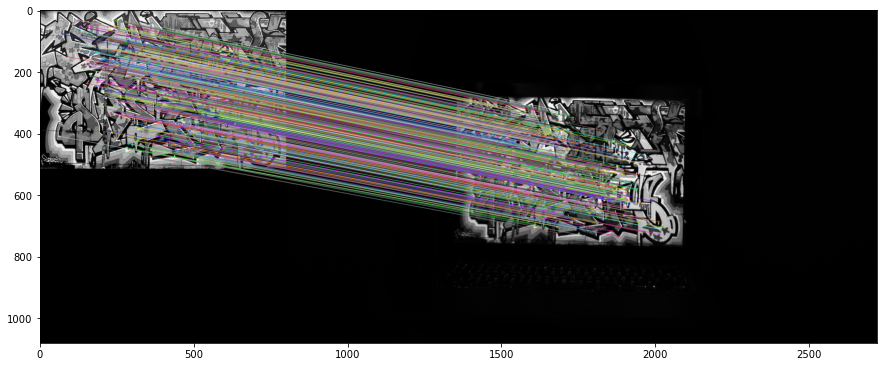

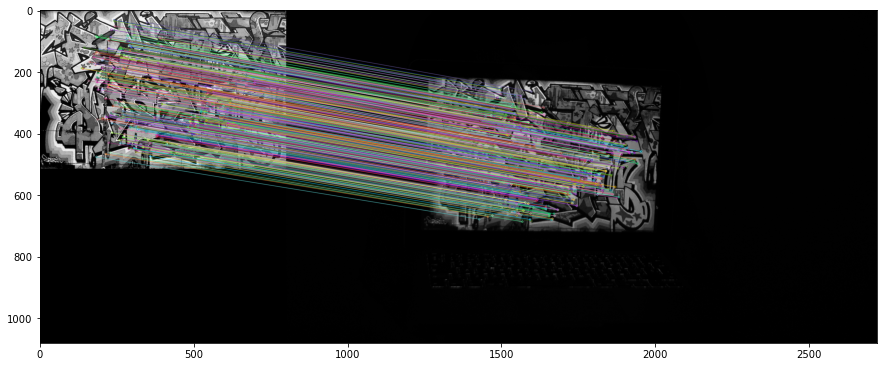

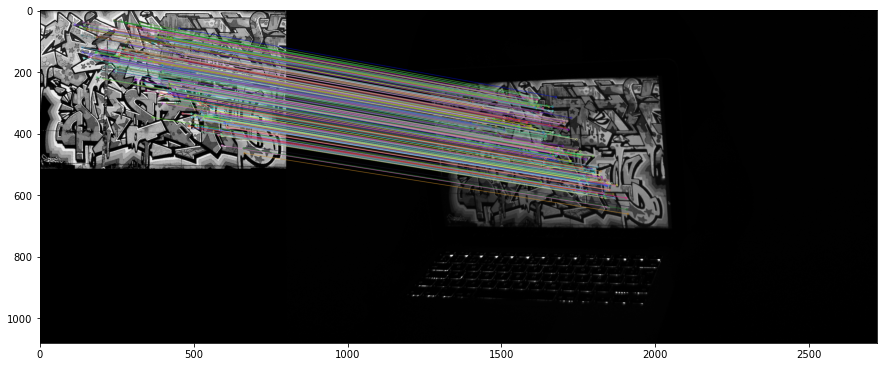

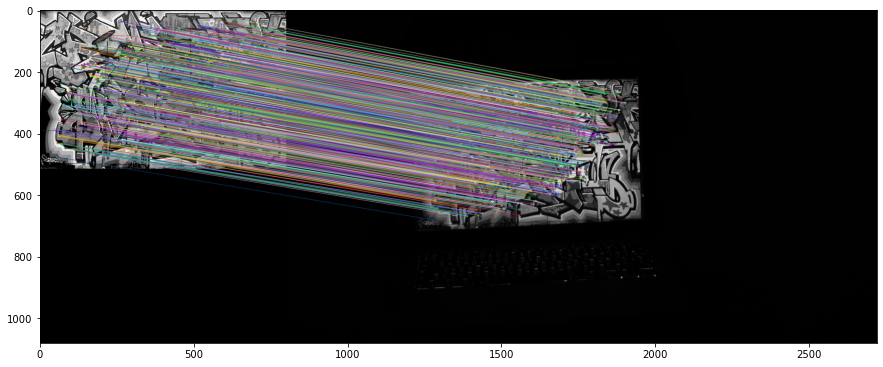

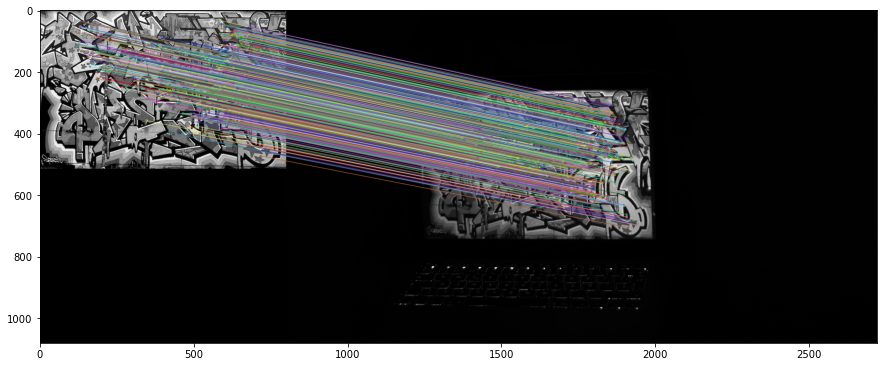

In [84]:

# Initiate ORB detector
orb = cv2.ORB_create(WTA_K=4, nfeatures=10000, scoreType=cv2.ORB_FAST_SCORE)#cv2.ORB_create()
# find the keypoints and descriptors with ORB
kpt, dest = orb.detectAndCompute(template,None)
kpi, desi = [], []
for m in images:
    kp, des = orb.detectAndCompute(m,None)
    kpi.append(kp)
    desi.append(des)


# Keypoint matching and homography estimation
bf = cv2.BFMatcher(normType=cv2.NORM_HAMMING)#cv2.BFMatcher()
H = []
for i in range(N):
    matches = bf.knnMatch(dest,desi[i],k=2)
    # Apply ratio test
    good_matches = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good_matches.append([m])
    
    # Fit homography and remove outliers
    points1 = []
    points2 = []
    for m in good_matches:
        points1.append([kpt[m[0].queryIdx].pt[0], kpt[m[0].queryIdx].pt[1], 1])
        points2.append([kpi[i][m[0].trainIdx].pt[0], kpi[i][m[0].trainIdx].pt[1], 1])
    
    points1 = np.asarray(points1)
    points1 = points1.T
    points2 = np.asarray(points2)
    points2 = points2.T
    
    Hi, indices_inlier_matches = Ransac_DLT_homography(points1, points2, 10, 5000) # IMPORTANT: changed from th=3 to 10, otherwise too few points
    H.append(Hi)
    
    # Show inlier matches
    inlier_matches = itemgetter(*indices_inlier_matches)(good_matches)
    img_12 = cv2.drawMatchesKnn(template,kpt,images[i],kpi[i],inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_12)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 9)
    plt.show()
    


In [85]:
"""
template_color = cv2.imread(os.path.join(DATA_PATH, 'calib/template.jpg'))
for i in range(N):
    im = apply_H_fixed_image_size(template_color, H[i], (0, 1800, 0, 1000))
    plt.imshow(im)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(10, 5)
    plt.show()
    
"""

"\ntemplate_color = cv2.imread(os.path.join(DATA_PATH, 'calib/template.jpg'))\nfor i in range(N):\n    im = apply_H_fixed_image_size(template_color, H[i], (0, 1800, 0, 1000))\n    plt.imshow(im)\n    fig = matplotlib.pyplot.gcf()\n    fig.set_size_inches(10, 5)\n    plt.show()\n    \n"

<span style='color:Green'> - Complete the code that computes the Image of the Absolute Conic. </span>

<span style='color:Green'> - Complete the code that computes the matrix of internak parameters, K. </span>

Note: there is a linalg.cholesky function both in numpy and scipy, you have to read the documentation of both and find out which is the proper one to use here.

<span style='color:Green'> - In the report, make some comments related to the obtained internal camera parameters and also comment their relation to the image size. </span>

In [183]:
def get_equations_from_homography(h):
    v11, v12, v22 = [(h[0,i]*h[0,j], 
                       h[0,i]*h[1,j] + h[1,i]*h[0,j],
                       h[0,i]*h[2,j] + h[2,i]*h[0,j],
                       h[1,i]*h[1,j],
                       h[1,i]*h[2,j] + h[2,i]*h[1,j],
                       h[2,i]*h[2,j]) 
                        for (i,j) in ((0,0), (0,1), (1, 1))]
    
    eq1 = np.array(v12)
    eq2 = np.array(np.array(v11) - np.array(v22))
    return eq1,eq2

# Compute the Image of the Absolute Conic ...
V = np.array([get_equations_from_homography(H[i]) for i in range(N)]).reshape((N*2,6))
U,D,Vt = np.linalg.svd(V)

w11, w12, w13, w22, w23, w33 = Vt[-1,:]
omega = np.array(((w11,w12,w13), (w12, w22, w23), (w13, w23, w33)))

print("> Omega:")
print(omega)

# Compute the matrix of internal parameters, K ...
K_inv = cholesky(omega)
#np.linalg.eigvals(omega)
K = np.linalg.inv(K_inv)

print("> K:")
print(K)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

<span style='color:Green'> - Complete the calculation of r1, r2, and ti in the code below. </span>

In [73]:
# Compute camera position and orientation
import math
R = []
t = []
P = []

K_inv = np.linalg.inv(K)
for i in range(N):
    # compute r1, r2, and t{i}
    h = H[i]
    r1 = K_inv @ h[:,0]# / np.linalg.norm(K_inv @ h[:,0]) # complete ...
    r2 = K_inv @ h[:,1]# / np.linalg.norm(K_inv @ h[:,1])
    ti = K_inv @ h[:,2]# / np.linalg.norm(K_inv @ h[:,2])
    
    # Solve the scale ambiguity by forcing r1 and r2 to be unit vectors.
    s = math.sqrt(np.linalg.norm(r1) * np.linalg.norm(r2)) * np.sign(ti[2])
    r1 = r1 / s
    r2 = r2 / s
    ti = ti / s
    t.append(ti)
    Ri = np.array([r1, r2, np.cross(r1,r2)])
    Ri = Ri.T
    
    # Ensure R is a rotation matrix
    U, d, Vt = np.linalg.svd(Ri)
    Ri = U @ np.identity(3) @ Vt
    R.append(Ri)
   
    # Pi = K * [Ri ti]
    A = np.zeros((3,4))
    A[:3,:3] = Ri
    A[:,3] = ti
    Pi = K @ A
    P.append(Pi)

The following code (no need to be completed) draws the planar pattern and the N camera locations (position and orientation).

<span style='color:Green'> - Take a look to the provided code for that and in the report explain how the optical center is computed. </span>

In [146]:
import plotly.graph_objects as go
from utils import plot_camera, plot_image_origin

ny, nx = images[0].shape

fig = go.Figure()
for i in range(N):
    plot_camera(P[i], nx, ny, fig, "camera{0}".format(i))

plot_image_origin(nx, ny, fig, "image")

fig.show()

Alternatively, we can draw a fixed camera and N planar patterns at different relative poses with respect to the camera.

<span style='color:Green'> -Complete the function ' plot_image_Rt' in order to achieve that. Note: it may be useful to look at function 'plot_image_origin' in utils.py</span>

In [40]:
def plot_image_origin(w, h, fig, legend):
    p1 = np.array([0, 0, 0])
    p2 = np.array([w, 0, 0])
    p3 = np.array([w, h, 0])
    p4 = np.array([0, h, 0])
    
    x = np.array([p1[0], p2[0], p3[0], p4[0], p1[0]])
    y = np.array([p1[1], p2[1], p3[1], p4[1], p1[1]])
    z = np.array([p1[2], p2[2], p3[2], p4[2], p1[2]])
    
    fig.add_trace(go.Scatter3d(x=x, y=z, z=-y, mode='lines',name=legend))
    
    return

In [147]:
def plot_image_Rt(R, t, w, h, fig, legend):
    Rt = np.zeros((3,4))
    Rt[:3,:3] = R
    Rt[:, 3] = t
    p1 = Rt@np.array([0, 0, 0, 1])
    p2 = Rt@np.array([w, 0, 0, 1])
    p3 = Rt@np.array([w, h, 0, 1])
    p4 = Rt@np.array([0, h, 0, 1])

    x = np.array([p1[0], p2[0], p3[0], p4[0], p1[0]])
    y = np.array([p1[1], p2[1], p3[1], p4[1], p1[1]])
    z = np.array([p1[2], p2[2], p3[2], p4[2], p1[2]])

    fig.add_trace(go.Scatter3d(x=x, y=z, z=-y, mode='lines',name=legend))
    
    return


fig = go.Figure()
A = np.zeros((3,4))
A[0,0]=A[1,1]=A[2,2]=1

plot_camera(K@A, nx, ny, fig, "camera")
for i in range(N):
    plot_image_Rt(R[i], t[i], nx, ny, fig, "image{0}".format(i))

plt.savefig("figs/camera_fixed.pdf")
fig.show()

<Figure size 432x288 with 0 Axes>

### **4.2 Augmented reality**

The following code (no need to be completed) draws a simple 3D virtual object (a cube) on top of the flat pattern.

<span style='color:Green'> - Analyse the provided code and in the report explain how the virtual object is inserted in the image and why the camera view needs to be calibrated. </span>

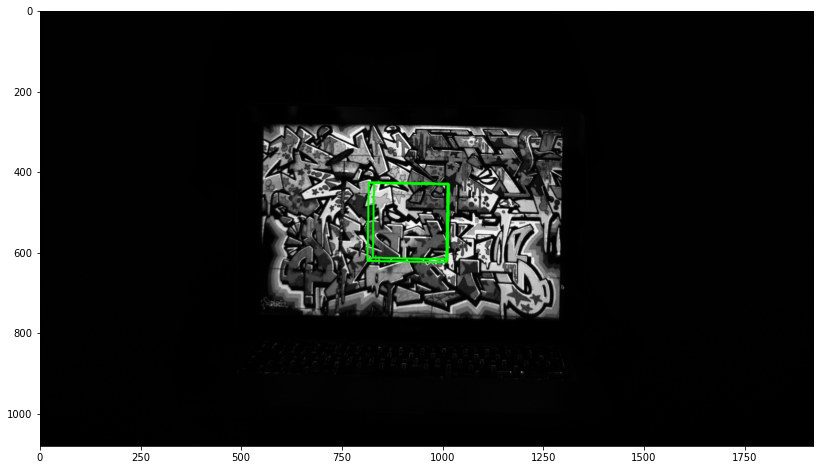

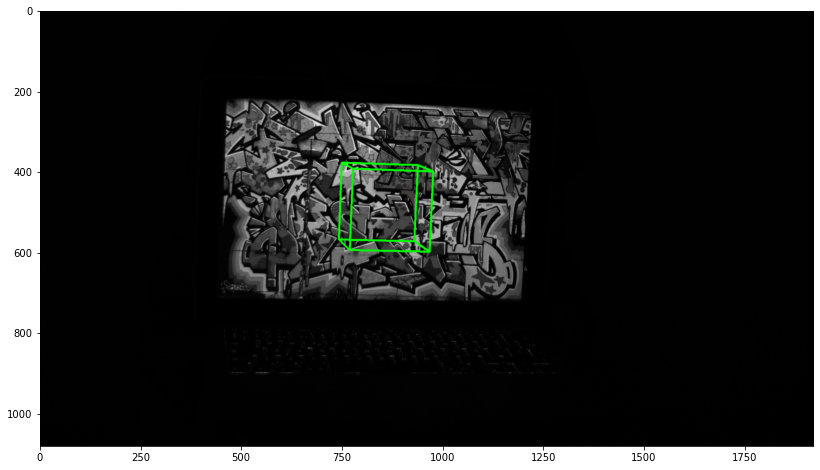

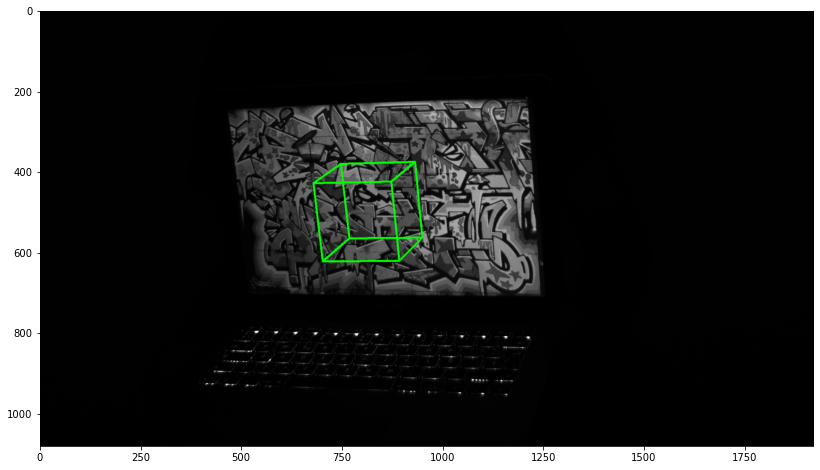

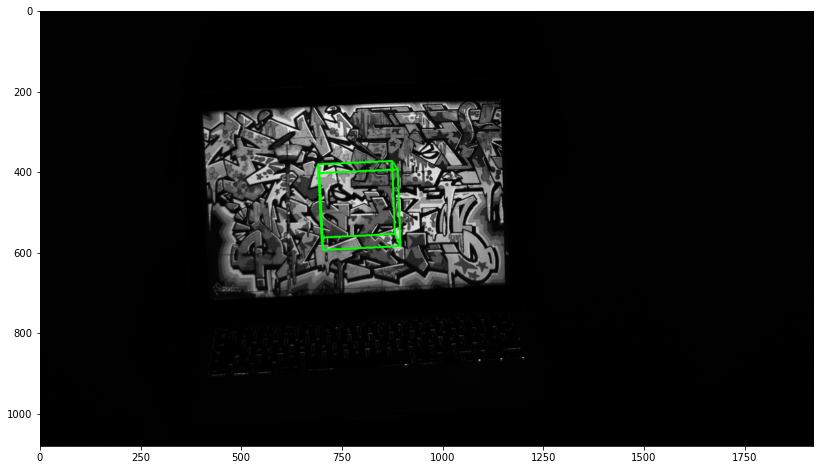

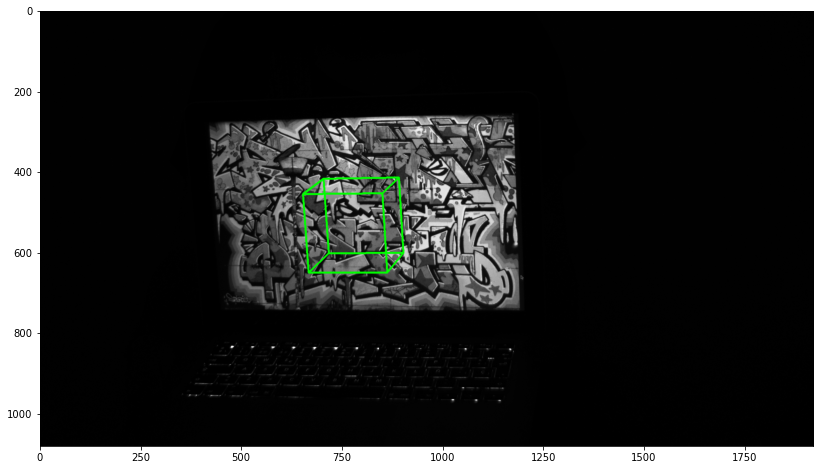

In [142]:

Th, Tw = template.shape
cube_corners = np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0], [0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1], [0, 0, 1], [0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1], [0, 0, 0], [0, 1, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1], [0, 1, 0]])

import numpy.matlib
offset = np.array([Tw/2, Th/2, -Tw/8])
M = cube_corners.shape[0]
X = (cube_corners - 0.5) * Tw/ 4 + np.matlib.repmat(offset, M, 1)

X = X.T
ones = np.ones(M)
Xh = np.stack((X[0,:], X[1,:], X[2,:], ones), axis=0)

line_color = (0, 255, 0)

for i in range(N):
    
    xp = P[i]@Xh
    xp = xp / xp[2,:]
    xp = xp.astype(int)
    
    image = cv2.imread(os.path.join(DATA_PATH, "calib/graffiti{0}.tif").format(i+1),cv2.IMREAD_COLOR)
    image_gray = image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray[:, :, 0] = gray[:, :]
    image_gray[:, :, 1] = image_gray[:, :, 0]
    image_gray[:, :, 2] = image_gray[:, :, 0]
    for j in range(M-1):
        image = cv2.line(image_gray, (xp[0,j],xp[1,j]), (xp[0,j+1],xp[1,j+1]), line_color, 4) 
    plt.imshow(image)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 8)
    plt.savefig(f"figs/cube{i}.pdf")
    plt.show()


## **5. OPTIONAL. Application: Logo detection +  6. OPTIONAL. Application: Logo replacement**

<span style='color:Green'> - Detect the UPF logo in the two UPF images using the DLT algorithm (folder "logos").
Interpret and comment the results. </span>

<span style='color:Green'> - Replace the UPF logo by the master logo in one of the previous images using the DLT algorithm. </span>

In [25]:
def add_ones_dim(x):
    return np.array([x[0],x[1],np.ones_like(x[1])])

def remove_ones_dim(x):
    x = x/x[2]
    return np.array([x[0],x[1]])




In [26]:
from scipy.optimize import least_squares
from math import ceil

def add_ones_dim(x):
    return np.array([x[0],x[1],np.ones_like(x[1])])

def remove_ones_dim(x):
    x = x/x[2]
    return np.array([x[0],x[1]])

def geometric_error_terms(variables, points):

    H = variables[:9].reshape(3,3)

    npoints = int(len(points)/2)
    x = points[:npoints]
    xp = points[npoints:]
    
    #reshape back to original sizes
    x = np.reshape(x,(2,-1))
    xp = np.reshape(xp,(2,-1))
    
    # get optimal x_hat and x_hatp
    xhat = variables[9:]
    xhat = np.reshape(xhat,(2,-1))
    xhatp = remove_ones_dim(H@add_ones_dim(xhat))
    
    def get_l2_dist(a,b):
        return np.sum(np.square(a - b), axis=0)
    
    e1 = get_l2_dist(x,xhat)
    e2 = get_l2_dist(xp, xhatp)
    
    #E = np.concatenate([e1,e2, H.flatten()])
    E = np.sqrt(e1+e2)
    return E

def refine_homography(H, points, kp1, kp2):

    points1 = []
    points2 = []

    for m in points:
        points1.append([kp1[m[0].queryIdx].pt[0], kp1[m[0].queryIdx].pt[1]])
        points2.append([kp2[m[0].trainIdx].pt[0], kp2[m[0].trainIdx].pt[1]])

    points1 = np.asarray(points1)
    points1 = points1.T
    points2 = np.asarray(points2)
    points2 = points2.T

    data_points = np.concatenate([points1.flatten(),points2.flatten()])
    variables0 = np.concatenate([H.flatten(),points1.flatten()])

    result = least_squares(geometric_error_terms, variables0, method='trf', args=([data_points]))#,  ftol=1,  verbose=1,)

    Pr = result.x
    Hr = np.reshape(Pr[:9],(3,3))

    xhat = Pr[9:]
    xhat = np.reshape(xhat,(2,-1))
    xhatp = remove_ones_dim(Hr@add_ones_dim(xhat))

    data_pointsr = np.concatenate([xhat.flatten(),xhatp.flatten()])
    variables0r = np.concatenate([Hr.flatten(), xhat.flatten()])

    #initial square error
    old_error = np.mean(geometric_error_terms(variables0, data_points)[:-9])
    print(f'Old error is {old_error}')

    #final square error
    new_error = np.mean(geometric_error_terms(variables0r, data_pointsr)[:-9])
    print(f'New Error is {new_error}')

    points1r = xhat
    points2r = xhatp

    return Hr, points1r, points2r, points1, points2



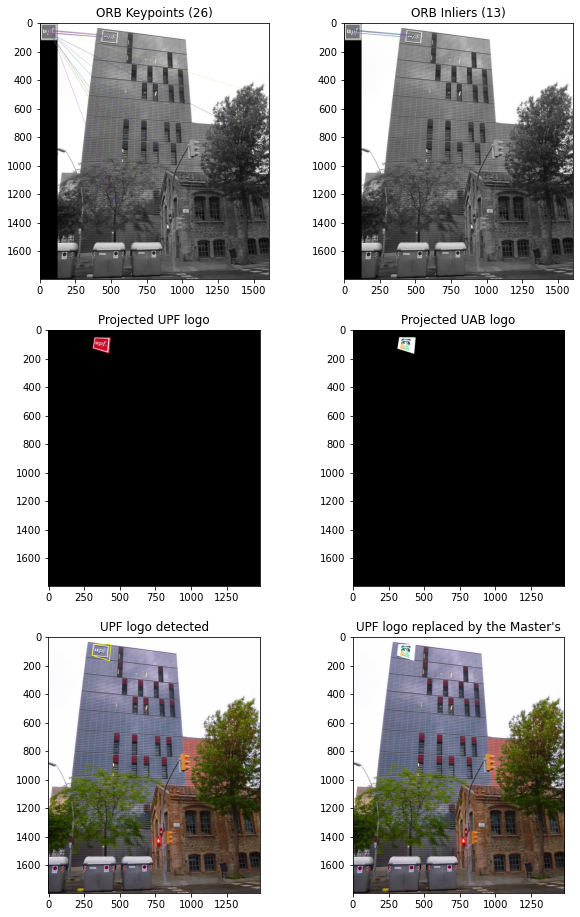

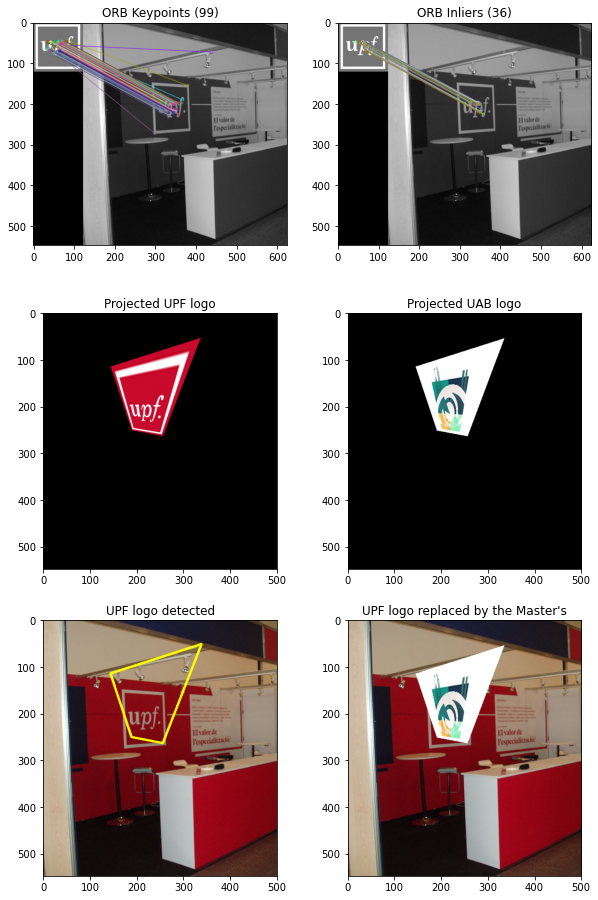

In [47]:
import random
seed = 3#5 for img1
random.seed(seed)
np.random.seed(seed)
cv2.setRNGSeed(seed)

# Read images
logo = cv2.imread(os.path.join(DATA_PATH, 'logos/logoUPF.png'),cv2.IMREAD_GRAYSCALE)
logo_color = cv2.imread(os.path.join(DATA_PATH, 'logos/logoUPF.png'))
logo_uab_color = cv2.imread(os.path.join(DATA_PATH, 'logos/logo_master.png'))

img_upf1 = cv2.imread(os.path.join(DATA_PATH, 'logos/UPFbuilding.jpg'),cv2.IMREAD_GRAYSCALE)
img_upf1_color = cv2.imread(os.path.join(DATA_PATH, 'logos/UPFbuilding.jpg'))
img_upf2= cv2.imread(os.path.join(DATA_PATH, 'logos/UPFstand.jpg'),cv2.IMREAD_GRAYSCALE)
img_upf2_color = cv2.imread(os.path.join(DATA_PATH, 'logos/UPFstand.jpg'))

# Generate keypoints for the logo
orb1 = cv2.ORB_create(WTA_K=4, scaleFactor=1.05, nlevels=64, nfeatures=1000000, scoreType=cv2.ORB_FAST_SCORE)
orb2 = cv2.ORB_create(WTA_K=4, scaleFactor=1.05, nlevels=64, nfeatures=1000000, scoreType=cv2.ORB_FAST_SCORE)
kpt_logo, des_logo = orb1.detectAndCompute(logo, None)

i=0
for (img, img_color, orb) in [(img_upf1, img_upf1_color, orb1), (img_upf2, img_upf2_color, orb2)]:

    # Initiate ORB detector
    # find the keypoints and descriptors with ORB
    kpt_img, des_img = orb.detectAndCompute(img, None)

    # Keypoint matching
    bf = cv2.BFMatcher(normType=cv2.NORM_HAMMING)
    matches_12 = bf.knnMatch(des_logo, des_img, k=2)
    # Apply ratio test
    good_matches = []
    for m,n in matches_12:
        if m.distance < 0.85*n.distance:
            good_matches.append([m])
            
    
    # Show "good" matches 
    img_kpts = cv2.drawMatchesKnn(logo, kpt_logo, img, kpt_img, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #plt.figure(0, figsize=(30,15))
    #plt.imshow(img_kpts)
    #plt.show()

    # Fit homography and remove outliers
    points1 = []
    points2 = []
    for m in good_matches:
        points1.append([kpt_logo[m[0].queryIdx].pt[0], kpt_logo[m[0].queryIdx].pt[1], 1])
        points2.append([kpt_img[m[0].trainIdx].pt[0], kpt_img[m[0].trainIdx].pt[1], 1])
    
    points1 = np.asarray(points1)
    points1 = points1.T
    points2 = np.asarray(points2)
    points2 = points2.T
    
    Hi, indices_inlier_matches = Ransac_DLT_homography(points1, points2, 15, 3000) # IMPORTANT: changed from th=3 to 10, otherwise too few points
    inlier_matches = itemgetter(*indices_inlier_matches)(good_matches)
    
    # Show inlier matches
    inlier_matches = itemgetter(*indices_inlier_matches)(good_matches)
    img_kpts_inliers = cv2.drawMatchesKnn(logo, kpt_logo, img, kpt_img, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #plt.figure(0, figsize=(30,15))
    #plt.imshow(img_kpts_inliers)
    #plt.show()
    
    # We apply the projective transformation to the corners of the logo to draw the rectangle
    # around it in the goal image.
    vertices = (Hi@np.array((0,0,1)), 
                Hi@np.array((logo.shape[1],0,1)), 
                Hi@np.array((logo.shape[1],logo.shape[0],1)),
                Hi@np.array((0,logo.shape[0],1)), )
    vertices = np.array([[v.astype(int)[:2] / v[2] for v in vertices]], np.int32) # from homogeneous to 2D coordinates
    img_detected = np.copy(img_color)
    cv2.polylines(img_detected, [vertices], isClosed=True, color=(0,255,255), thickness=3) # rectangle drawing
    
    dims = (0, img_color.shape[1]-1, 0, img_color.shape[0]-1)
    
    # we resize the UAB logo
    resized_uab = cv2.resize(logo_uab_color, logo.shape, interpolation = cv2.INTER_LINEAR)
    im_resized_uab = apply_H_fixed_image_size(resized_uab, Hi, dims)
    
    im_logo_upf = apply_H_fixed_image_size(logo_color, Hi, dims)
    img_color = np.copy(img_color)
    img_color[im_resized_uab != (0,0,0)] = im_resized_uab[im_resized_uab != (0,0,0)]
    
    fig, ax = plt.subplots(3,2, figsize=(10,16))
    ax[0,0].set_title(f"ORB Keypoints ({len(good_matches)})")
    ax[0,0].imshow(img_kpts)
    ax[0,1].set_title(f"ORB Inliers ({len(indices_inlier_matches)})")
    ax[0,1].imshow(img_kpts_inliers)
    ax[1,0].set_title("Projected UPF logo")
    ax[1,0].imshow(cv2.cvtColor(im_logo_upf, cv2.COLOR_BGR2RGB))
    ax[1,1].set_title("Projected UAB logo")
    ax[1,1].imshow(cv2.cvtColor(im_resized_uab, cv2.COLOR_BGR2RGB))
    ax[2,0].set_title("UPF logo detected")
    ax[2,0].imshow(cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB))
    ax[2,1].set_title("UPF logo replaced by the Master's")
    ax[2,1].imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
    plt.savefig(f"figs/logo_det_{i}.pdf")
    plt.show()
    i+=1

In [233]:
"""
for (img, img_color) in [(img2, img2_color),]:#, (img1, img1_color)]:

    # Initiate ORB detector
    # find the keypoints and descriptors with ORB
    kpi, des2 = orb.detectAndCompute(img,None)

    # Keypoint matching
    bf = cv2.BFMatcher(normType=cv2.NORM_HAMMING)
    matches_12 = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    good_matches = []
    for m,n in matches_12:
        if m.distance < 0.85*n.distance:
            good_matches.append([m])
            
    
    # Show "good" matches 
    img_1 = cv2.drawMatchesKnn(logo,kpt,img,kpi,good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_1)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(10, 4)
    plt.show()

    # Fit homography and remove outliers
    points1 = []
    points2 = []
    for m in good_matches:
        points1.append([kpt[m[0].queryIdx].pt[0], kpt[m[0].queryIdx].pt[1], 1])
        points2.append([kpi[m[0].trainIdx].pt[0], kpi[m[0].trainIdx].pt[1], 1])
    
    points1 = np.asarray(points1)
    points1 = points1.T
    points2 = np.asarray(points2)
    points2 = points2.T
    
    Hi, indices_inlier_matches = Ransac_DLT_homography(points1, points2, 5, 3000) # IMPORTANT: changed from th=3 to 10, otherwise too few points

    # Show inlier matches
    inlier_matches = itemgetter(*indices_inlier_matches)(good_matches)
    img_1 = cv2.drawMatchesKnn(logo,kpt,img,kpi,inlier_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_1)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(10, 4)
    plt.show()
    
    # We apply the projective transformation to the corners of the logo to draw the rectangle
    # around it in the goal image.
    vertices = (Hi@np.array((0,0,1)), 
                Hi@np.array((logo.shape[1],0,1)), 
                Hi@np.array((logo.shape[1],logo.shape[0],1)),
                Hi@np.array((0,logo.shape[0],1)), )
    vertices = np.array([[v.astype(int)[:2] / v[2] for v in vertices]], np.int32) # from homogeneous to 2D coordinates
    cv2.polylines(img_color, [vertices], isClosed=True, color=(0,255,255), thickness=3) # rectangle drawing
    
    im = apply_H_fixed_image_size(logo_color, Hi, (0, 700, 0, 600))
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(im)
    ax[1].imshow(img_color)
    plt.show()
    """
pass